In [1]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration
import torch, os, glob, json, math
from torch import nn
import numpy as np
import onnxruntime as ort
import inspect

folder = './musicgen-small'
os.makedirs(folder, exist_ok=True)

cfg = 3
temperature = 0.7
top_k = 250
top_p = 0.5
max_len = 256

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoProcessor.from_pretrained("facebook/musicgen-stereo-small")
inputs = processor(
    text=["80s pop track with bassy drums and synth"],
    padding=True,
    return_tensors="pt",
)

In [3]:
def softmax(x, axis=-1):
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Step 2: Multinomial sampling from probabilities
def multinomial(probs, num_samples=1):
    # Create an empty array to hold sampled tokens
    batch_size, seq_len, vocab_size = probs.shape
    sampled_tokens = np.zeros((batch_size, seq_len), dtype=np.int32)
    
    for i in range(batch_size):
        for j in range(seq_len):
            # Use np.random.choice to sample from the vocabulary based on probabilities
            sampled_tokens[i, j] = np.random.multinomial(p=probs[i, j, :]).squeeze()
    
    return sampled_tokens

In [4]:
def apply_mask(decoder_pattern_mask, ids):
    seq_len = ids.shape[-1]
    decoder_pattern_mask = decoder_pattern_mask[..., :seq_len]
    return np.where(decoder_pattern_mask == -1, ids, decoder_pattern_mask)
    

In [5]:
ort_session_mask = ort.InferenceSession(f"{folder}/build_delay_pattern_mask.onnx")

_, decoder_pattern_mask = ort_session_mask.run(None, {
    'input_ids': np.ones((4,16), dtype=np.int64) * -1,
    'pad_token_id': np.array([2048], dtype=np.int64),
    'max_length': np.array([256], dtype=np.int64),
})

2024-10-18 00:07:48.536530163 [W:onnxruntime:, execution_frame.cc:870 VerifyOutputSizes] Expected shape from model of {-1,16} does not match actual shape of {4,1} for output input_ids_edited


In [9]:
inputs['input_ids'].shape

torch.Size([1, 12])

In [10]:
inputs['attention_mask'].shape

torch.Size([1, 12])

In [16]:
attention_mask_np = inputs['attention_mask'].detach().numpy()
attention_mask_np = np.concatenate([attention_mask_np, np.zeros_like(attention_mask_np)], axis=0)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [13]:
encoded.shape

(1, 12, 768)

In [11]:
ort_session = ort.InferenceSession(f"{folder}/text_encoder.onnx")

input_ids_np = inputs['input_ids'].detach().numpy()
attention_mask_np = inputs['attention_mask'].detach().numpy()

# Run the model
ort_inputs = {
    'input_ids': input_ids_np,
    'attention_mask': attention_mask_np
}
encoded = ort_session.run(None, ort_inputs)[0]
raise

ort_session = ort.InferenceSession(f"{folder}/decoder_model.onnx")

ort_inputs = {
    'encoder_attention_mask': attention_mask_np, 
    'input_ids': np.ones((4,1), dtype=np.int64) * 2048, 
    'encoder_hidden_states': encoded, 
}

for i in range(max_len - 1):
    print(i, end='\r')
    ort_inputs['input_ids'] = apply_mask(decoder_pattern_mask, ort_inputs['input_ids'])
    logits = ort_session.run(None, ort_inputs)[0]
    logits = logits[:, -1, :][:, None]
    # Apply temperature
    if temperature > 0.0:
        logits = logits / temperature

    # Top K sampling
    top_k_indices = np.argsort(logits)[:,:,-top_k:]
    top_k_probs = np.take_along_axis(logits, top_k_indices, axis=-1)

    # Softmax
    top_k_probs = softmax(top_k_probs, axis=-1)

    # Top
    sorted_indices = np.argsort(top_k_probs, axis=-1)[..., ::-1]
    sorted_probs = np.take_along_axis(top_k_probs, sorted_indices, axis=-1)

    # Top p 
    if top_p < 1.0:
        sorted_indices = np.argsort(top_k_probs, axis=-1)[..., ::-1]
        sorted_probs = np.take_along_axis(top_k_probs, sorted_indices, axis=-1)

        cumulative_probs = np.cumsum(sorted_probs, axis=-1)

        sorted_indices_to_keep = cumulative_probs <= (1 - top_p)
        sorted_indices_to_keep[..., 0] = True
        filtered_probs = np.where(sorted_indices_to_keep, sorted_probs, 0)
        filtered_probs = softmax(filtered_probs, axis=-1) # Chaning this to a different sampling could fix my life.
        top_k_probs = filtered_probs

    # Sample
    logits = np.array([[top_k_indices[i, : , sorted_indices[i, :, np.random.multinomial(1, codebook, size=(1,)).argmax()]]] for i, codebook in enumerate(top_k_probs.squeeze())]).squeeze()[:, None]

    # logits = np.argmax(logits, axis=-1)[:, -1]
    ort_inputs['input_ids'] = np.concatenate((ort_inputs['input_ids'], logits), axis=-1)

RuntimeError: No active exception to reraise

In [ ]:
ort_inputs['input_ids']


array([[2048,  495, 1983, ..., 2048, 2048, 1763],
       [2048, 2048,  437, ..., 1866, 2048,   59],
       [2048, 2048, 2048, ..., 2040, 1721, 1702],
       [2048, 2048, 2048, ..., 2038, 1212,  428]], dtype=int64)

In [ ]:
output_ids = ort_inputs['input_ids']
output_ids = apply_mask(decoder_pattern_mask, output_ids)
output_ids = output_ids[output_ids != 2048].reshape(
    1, 4, -1
)

# append the frame dimension back to the audio codes
output_ids = output_ids[None, ...]

In [ ]:
output_ids.shape

array([[[[ 495, 1983,  419, ...,  868,  840,  722],
         [ 437,  761,  541, ..., 1469,  577, 1866],
         [ 768,  975, 1612, ..., 1879, 2040, 1721],
         [ 380, 1426, 1641, ..., 2038, 1212,  428]]]], dtype=int64)

In [ ]:
ort_session = ort.InferenceSession(f"{folder}/encodec_decode.onnx")

output_values = ort_session.run(None, {'audio_codes': output_ids})[0]

In [ ]:
from IPython.display import Audio

sampling_rate = 32000
Audio(output_values[0], rate=sampling_rate)

In [ ]:
import matplotlib.pyplot as plt

def plot_stereo_audio_from_array(audio_data):
    """
    Plots the left and right channels of a stereo audio signal.

    Parameters:
    audio_data (numpy array): A 2D NumPy array with shape (channels, samples).
    sample_rate (int): The sample rate of the audio signal.
    """
    # Check if the audio is stereo (2 channels)
    if audio_data.shape[0] == 2:
        # Extract the left and right channels
        left_channel = audio_data[0, :]
        right_channel = audio_data[1, :]

        # Create time axis in seconds
        time = [i / 32000 for i in range(audio_data.shape[1])]

        # Plot the left and right channels
        plt.figure(figsize=(12, 6))

        # Plot left channel
        plt.subplot(2, 1, 1)
        plt.plot(time, left_channel, color='blue')
        plt.title('Left Channel')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Plot right channel
        plt.subplot(2, 1, 2)
        plt.plot(time, right_channel, color='green')
        plt.title('Right Channel')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        left_channel = audio_data[0, :]

        # Create time axis in seconds
        time = [i / 32000 for i in range(audio_data.shape[1])]

        # Plot the left and right channels
        plt.figure(figsize=(12, 6))

        # Plot left channel
        plt.subplot(2, 1, 1)
        plt.plot(time, left_channel, color='blue')
        plt.title('Left Channel')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Show the plot
        plt.tight_layout()
        plt.show()

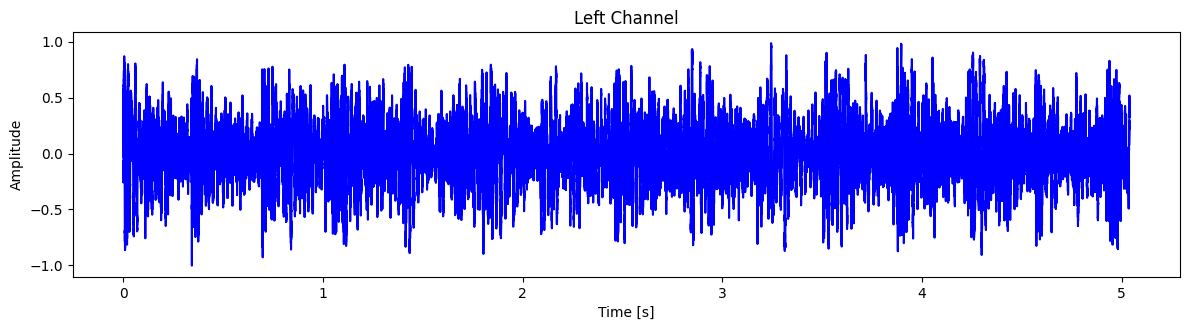

In [ ]:
plot_stereo_audio_from_array(output_values[0])

In [ ]:
raise

RuntimeError: No active exception to reraise

In [14]:
import onnx
onnx_model = onnx.load(f"musicgen-small/text_encoder.onnx")

# Check the model’s inputs
input_all = onnx_model.graph.input
output_all = onnx_model.graph.output

print("Inputs:")
for input in input_all:
    input_name = input.name
    input_shape = [dim.dim_value for dim in input.type.tensor_type.shape.dim]
    input_type = input.type.tensor_type.elem_type
    print(f"Name: {input_name}, Shape: {input_shape}, Type: {input_type}")

print("\nOutputs:")
for output in output_all:
    output_name = output.name
    output_shape = [dim.dim_value for dim in output.type.tensor_type.shape.dim]
    output_type = output.type.tensor_type.elem_type
    print(f"Name: {output_name}, Shape: {output_shape}, Type: {output_type}")

Inputs:
Name: input_ids, Shape: [0, 0], Type: 7
Name: attention_mask, Shape: [0, 0], Type: 7

Outputs:
Name: last_hidden_state, Shape: [0, 0, 768], Type: 1


In [2]:
import onnx
onnx_model = onnx.load(f"musicgen-small/build_delay_pattern_mask.onnx")

# Check the model’s inputs
input_all = onnx_model.graph.input
output_all = onnx_model.graph.output

print("Inputs:")
for input in input_all:
    input_name = input.name
    input_shape = [dim.dim_value for dim in input.type.tensor_type.shape.dim]
    input_type = input.type.tensor_type.elem_type
    print(f"Name: {input_name}, Shape: {input_shape}, Type: {input_type}")

print("\nOutputs:")
for output in output_all:
    output_name = output.name
    output_shape = [dim.dim_value for dim in output.type.tensor_type.shape.dim]
    output_type = output.type.tensor_type.elem_type
    print(f"Name: {output_name}, Shape: {output_shape}, Type: {output_type}")

Inputs:
Name: input_ids, Shape: [0, 16], Type: 7
Name: pad_token_id, Shape: [1], Type: 7
Name: max_length, Shape: [1], Type: 7

Outputs:
Name: input_ids_edited, Shape: [0, 16], Type: 7
Name: delay_pattern_mask, Shape: [0, 0], Type: 7
